# TEMPLATE FOR WORKFLOW


In [25]:
import functions_combined_BEST as ji
from functions_combined_BEST import ihelp,reload,ihelp_menu
import my_keras_functions as mk
from my_imports import *
# import warnings
# warnings.filterwarnings('ignore')
reload(mk)
reload(ji)

ji.quiet_mode()

In [26]:
# Display the ihelp for stock data processing
functions_used = ['load_processed_stock_data','plotly_time_series','def_data_params',
                  'train_test_split_by_last_days','make_scaler_library','transform_cols_from_library',
                  'make_train_test_series_gens','def_callbacks_and_params','def_compile_params_optimizer']
ihelp_menu(functions_used)

interactive(children=(Checkbox(value=False, description='show_help'), Checkbox(value=True, description='show_s…

In [ ]:
# Load stock_df data from functions detailed above
stock_df = ji.load_processed_stock_data()
stock_df.head()

ji.plotly_time_series(stock_df['price']);

In [17]:
## Define data parameters for train_test_split 
model_params={}
model_params['data_params'] = ji.def_data_params(stock_df,
                                                 num_test_days=45, num_train_days=365, 
                                                 days_for_x_window=5, verbose=0)

###### TRAIN TEST SPLIT BY NUMBER OF DAYS ######
dp = model_params['data_params']
df_train, df_test = ji.train_test_split_by_last_days(stock_df,
                                                     periods_per_day = dp['periods_per_day'], 
                                                     num_test_days   =  dp['num_test_days'],
                                                     num_train_days  =  dp['num_train_days'],
                                                     verbose=0, iplot=False)


###### RESCALE DATA USING MinMaxScalers FIT ON TRAINING DATA's COLUMNS ######
scaler_library, df_train, model_params = ji.make_scaler_library(df_train, 
                                                                transform=True,
                                                                model_params=model_params,
                                                                verbose=0)
df_test = ji.transform_cols_from_library(df_test,scaler_library,inverse=False)

# Show transformed dataset
display( df_train.head(2).round(3).style.set_caption('training data'),
        df_test.head(2).round(3).style.set_caption('test data'))

>> File found. Loading _stock_df_with_technical_indicators.csv
DatetimeIndex(['2016-12-29 15:30:00', '2019-06-21 15:30:00'], dtype='datetime64[ns]', name='date_time_index', freq=None) <CustomBusinessHour: CBH=09:30-16:30>


------------ Parameters for Keras Model ------------


interactive(children=(Dropdown(description='dict_to_display', options={'data_params': {'num_test_days': 45, 'n…

In [18]:
funcs_make_model = ['make_train_test_series_gens','def_callbacks_and_params',
                  'def_compile_params_optimizer','make_model1'] 

funcs_fit_eval_model=['fit_model', 'evaluate_model_plot_history',
                  'get_predictions_df_and_evaluate_model', 'compare_time_shifted_model']

ihelp_menu(funcs_make_model)

interactive(children=(Checkbox(value=False, description='show_help'), Checkbox(value=True, description='show_s…

In [ ]:
# Create timeseries generators
train_generator, test_generator, model_params =\
    ji.make_train_test_series_gens( df_train['price'], df_test['price'],
                                   model_params,verbose=0)

# Create ModelCheckpoint and early Stopping callbacks
callbacks, model_params = \
    ji.def_callbacks_and_params(model_params, loss_function='my_rmse',
                               checkpoint_mode='min', stop_mode = 'min',
                                patience=1, min_delta=0.001, verbose=1)


model_params = ji.def_compile_params_optimizer(
    loss='my_rmse', metrics=['acc','my_rmse'],
    optimizer='optimizers.Nadam()', model_params=model_params)

model1=ji.make_model1(model_params)

# Display all parameters used to create model
ji.display_dict_dropdown(model_params,title='Parameters for Keras Model')

In [19]:
# fit and evaluate model
model,model_params,history = ji.fit_model(model,train_generator,
                                          model_params=model_params,
                                          epochs=5,callbacks=callbacks)

eval_results = ji.evaluate_model_plot_history(model, train_generator, test_generator)

df_model1 = ji.get_predictions_df_and_evaluate_model(model,
                                                     train_generator, test_generator,
                                                     true_train_data = df_train['price'], 
                                                     true_test_data = df_test['price'], 
                                                     model_params=model_params,
                                                     inverse_scale=True,
                                                     plot_results=False, iplot_results=True)

res_df = ji.compare_time_shifted_model(df_model1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 35, 50)            10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


None

import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
------------------------------------------------------------
	FITTING MODEL:
------------------------------------------------------------ 

--- CLOCK STARTED @:    07/27/19 - 09:27:12 PM           Label:            --- 
Epoch 1/1
 - 96s - loss: 0.0347 - acc: 7.9334e-04 - my_rmse: 0.0347

Epoch 00001: saving model to models/checkpoints/model1_weights__07-27-2019_0927pm.hdf5
--- TOTAL DURATION   =  1 min, 37.600 sec --- 


Lap #,Start Time,Duration,Label
TOTAL,07/27/19 - 09:27:12 PM,"1 min, 37.600 sec",




------------------------------------------------------------------------------------
	EVALUATE MODEL:
------------------------------------------------------------------------------------


,Training Data,Test Data
acc,0.000793,0.000000
loss,0.016353,0.015031
my_rmse,0.016353,0.015031


,Value
Metric,
R_squared,0.958
Root Mean Squared Error,0.479
Thiel's U,1.165


,R_squared,Root Mean Squared Error,Thiel's U
Bins Shifted,,,
-4,0.932,0.604,1.456
-3,0.963,0.445,1.076
-2,0.986,0.272,0.662
-1,0.986,0.273,0.667
0,0.958,0.479,1.165
1,0.93,0.616,1.497
2,0.903,0.723,1.755
3,0.88,0.805,1.952


# UPDATED MODELING - PARTIALLY USING FUNCTIONS

## MODEL 1 - 08/06/19

#### NOTE ON PARAMETERS TO CHANGE:
- PARAMETERS TO CHANGE ARE LOCATED WITHIN HASHTAG COMMENTED BANNER SECTIONS
    - Header = `######## Name of section to be edited #######`
    - Footer = `#############################################`
    <br><br>
- **For `ji.def_data_params`:**
    - `num_test_days` = number of days left for test dataset
    - `num_train_days` = number of days prior to test_days to use as training dataset
    - `days_for_x_window` = number of days that should be analyzed together (binned for predictions)
    
    
- **For `ji.make_train_test_series_gens`:**
    - `n_features` = number of features/cols to use (for first model, =1, for second model =# of columns)
    - `batch_size` = 1 -  recommendation for timeseries predictions
    
    
- **For `_def_callbacks_and_params_`:**
    - `loss_function` for model checkpoints
    - `patience` = # of epochs without change before early stopping
    - `min_delta` = threshold for change to be considered significant (and therefore counts as new result)
    <br><br>
    
- **For `_def_callbacks_and_params_`:**
    - `loss` = Loss function for training
    -  `metrics` = Metrics to track during fit (['acc','mae'],)
    - `optimizer`= Optimizer to use during compiling ('optimizers.Nadam())

In [17]:
## IMPORT PACKAGES
from bs_ds.imports import *
import functions_combined_BEST as ji
import my_keras_functions as jik

# Import some functions directly
from functions_combined_BEST import ihelp, ihelp_menu, reload

# Import plotly and cufflinks for iplots
import plotly
import cufflinks as cf
cf.go_offline()

# Reload modules in case files have been updated
reload(jik)
reload(ji)

Reloading my_keras_functions...
Reloading functions_combined_BEST...


<module 'functions_combined_BEST' from 'D:\\Users\\James\\Dropbox (Personal)\\CODING\\_FLATIRON\\Mod5_FinalProject\\dsc-5-capstone-project-online-ds-ft-021119\\functions_combined_BEST.py'>

In [8]:
# Load stock_df data from functions detailed above
stock_df = ji.load_processed_stock_data()
stock_df.head()

>> File found. Loading _stock_df_with_technical_indicators.csv
DatetimeIndex(['2016-12-29 15:30:00', '2019-06-21 15:30:00'], dtype='datetime64[ns]', name='date_time_index', freq=None) <CustomBusinessHour: CBH=09:30-16:30>


,Date,Time,BidOpen,BidHigh,BidLow,BidClose,AskOpen,AskHigh,AskLow,AskClose,...,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,date_time_index
date_time_index,,,,,,,,,,,,,,,,,,,,,
2016-12-29 15:30:00,12/29/2016,15:30,96.25,96.27,96.24,96.27,96.26,96.28,96.25,96.28,...,96.277007,96.573856,96.730494,0.156639,1.002051,98.281110,94.272904,96.263988,89.27,2016-12-29 15:30:00
2016-12-30 09:30:00,12/30/2016,09:30,96.32,96.39,96.32,96.38,96.48,96.48,96.39,96.42,...,96.293537,96.571218,96.721997,0.150779,0.980655,98.254848,94.332227,96.341329,89.38,2016-12-30 09:30:00
2016-12-30 10:30:00,12/30/2016,10:30,96.18,96.21,96.17,96.21,96.19,96.21,96.18,96.21,...,96.307891,96.566317,96.709593,0.143275,0.959724,98.227340,94.388442,96.253776,89.21,2016-12-30 10:30:00
2016-12-30 11:30:00,12/30/2016,11:30,96.29,96.34,96.29,96.34,96.30,96.35,96.30,96.35,...,96.322653,96.563255,96.700645,0.137390,0.938272,98.199196,94.446110,96.311259,89.34,2016-12-30 11:30:00
2016-12-30 12:30:00,12/30/2016,12:30,96.25,96.25,96.25,96.25,96.26,96.26,96.26,96.26,...,96.336531,96.559027,96.689742,0.130715,0.912397,98.161325,94.511736,96.270420,89.25,2016-12-30 12:30:00


In [9]:
################# USER PARAMETERS: Define data parameters for train_test_split  ##############
model_params={}
model_params['data_params'] = ji.def_data_params(stock_df,
                                                 num_test_days=5, num_train_days=365, 
                                                 days_for_x_window=1, verbose=0)
###############################################################################################


###### TRAIN TEST SPLIT BY NUMBER OF DAYS ######
dp = model_params['data_params']
df_train, df_test = ji.train_test_split_by_last_days(stock_df,
                                                     periods_per_day = dp['periods_per_day'], 
                                                     num_test_days   =  dp['num_test_days'],
                                                     num_train_days  =  dp['num_train_days'],
                                                     verbose=0, iplot=False)

display(df_train.head(2).style.set_caption('df_train - pre-scaling'))
# ji.display_dict_dropdown(model_params)

###### RESCALE DATA USING MinMaxScalers FIT ON TRAINING DATA's COLUMNS ######
scaler_library, df_train, model_params = ji.make_scaler_library(df_train, 
                                                                transform=True,
                                                                model_params=model_params,
                                                                verbose=2)

df_test = ji.transform_cols_from_library(df_test,col_list=None,col_scaler_dict=scaler_library,
                                                      scaler_library=scaler_library,inverse=False)

# Show transformed dataset
display( df_train.head(2).round(3).style.set_caption('training data - scaled'))#,
#         df_test.head(2).round(3).style.set_caption('test data'))



################# USER PARAMETERS: Define n_Features and batch sizes for generators  ##############
# Create timeseries generators
train_generator, test_generator, model_params =\
    ji.make_train_test_series_gens( df_train['price'], df_test['price'],
                                   n_features=1,batch_size=1, model_params=model_params,
                                   verbose=0)
ji.display_dict_dropdown(model_params)
###############################################################################################

# # ji.display_dict_dropdown(model_params)
# funcs_make_model = ['make_train_test_series_gens','def_callbacks_and_params',
#                   'def_compile_params_optimizer','make_model1'] 
# ihelp_menu(funcs_make_model)

,Date,Time,BidOpen,BidHigh,BidLow,BidClose,AskOpen,AskHigh,AskLow,AskClose,date_time_index.1,filled_timebin,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,date_time_index
date_time_index,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-22 09:30:00,01/22/2018,09:30,114.34,114.34,114.34,114.34,114.5,114.5,114.5,114.5,2018-01-22 09:30:00,False,114.34,113.986,112.042,111.798,113.236,1.43854,1.55789,115.158,108.927,114.382,107.34,2018-01-22 09:30:00
2018-01-22 10:30:00,01/22/2018,10:30,115.06,115.06,115.03,115.03,115.07,115.07,115.04,115.04,2018-01-22 10:30:00,False,115.03,114.029,112.075,111.833,113.278,1.44542,1.56858,115.212,108.938,114.814,108.03,2018-01-22 10:30:00


These columns were excluded due to incompatible dtypes.
['Date', 'Time', 'date_time_index.1', 'filled_timebin', 'date_time_index']



,Date,Time,BidOpen,BidHigh,BidLow,BidClose,AskOpen,AskHigh,AskLow,AskClose,date_time_index.1,filled_timebin,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,date_time_index
date_time_index,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-22 09:30:00,01/22/2018,09:30,0.876,0.876,0.877,0.877,0.882,0.881,0.882,0.882,2018-01-22 09:30:00,False,0.877,0.878,0.763,0.75,0.828,0.94,0.254,0.669,0.738,0.878,0.877,2018-01-22 09:30:00
2018-01-22 10:30:00,01/22/2018,10:30,0.907,0.907,0.906,0.906,0.906,0.906,0.906,0.906,2018-01-22 10:30:00,False,0.906,0.88,0.765,0.752,0.831,0.942,0.256,0.673,0.738,0.896,0.906,2018-01-22 10:30:00


Using TensorFlow backend.


------------ Dictionary Contents ------------


interactive(children=(Dropdown(description='dict_to_display', options={'data_params': {'num_test_days': 5, 'nu…

In [10]:
def _def_callbacks_and_params_(model_params=None,loss_function='mae',checkpoint_mode='min',filepath=None,
                             stop_mode='min',patience=1,min_delta=.001,verbose=1):
    import functions_combined_BEST as ji
    

            ########## Define loss function and callback params ##########
    callback_params ={}
    callback_params['custom_loss_function'] = loss_function
    callback_params['ModelCheckpoint'] = {'monitor': loss_function, 'mode':checkpoint_mode}
    callback_params['EarlyStopping'] = {'monitor':loss_function, 'mode':stop_mode, 
                                        'patience':patience, 'min_delta':min_delta}

    # CREATING CALLBACKS
    from keras import callbacks

    if filepath is None:
        filepath = f"models/checkpoints/model1_weights_{ji.auto_filename_time(prefix=None)}.hdf5"

    if 'my_rmse' in loss_function:
        import functions_combined_BEST as ji
        loss_function = ji.my_rmse
#         my_rmse=my_rmse
#         loss_function = my_rmse

    # Create ModelCheckPoint
    fun_params=callback_params['ModelCheckpoint']
    checkpoint = callbacks.ModelCheckpoint(filepath=filepath, monitor=loss_function, mode=fun_params['mode'],
                                           save_best_only=True, verbose=verbose)
    # Create EarlyStopping
    fun_params=callback_params['EarlyStopping']
    early_stop = callbacks.EarlyStopping(monitor=loss_function, mode=fun_params['mode'], patience=fun_params['patience'],
                                         min_delta=fun_params['min_delta'],verbose=verbose)
    callbacks = [checkpoint,early_stop]

    if model_params is None:
        model_params=callback_params
    else:
        model_params['callbacks'] = callback_params
    return callbacks, model_params

################# USER PARAMS: Create ModelCheckpoint and early Stopping callbacks ###################
callbacks, model_params = \
    _def_callbacks_and_params_(model_params, loss_function='my_rmse',
                               checkpoint_mode='min', stop_mode = 'min',
                                patience=1, min_delta=0.001, verbose=1)
######################################################################################################


def _def_compile_params_optimizer_(loss='my_rmse',metrics=['acc','my_rmse'],optimizer='optimizers.Nadam()',model_params=None):
    ####### Specify additional model parameters
    from keras import optimizers
         
    compile_params={}
    compile_params['loss']= loss#{'my_rmse':my_rmse}
    compile_params['metrics'] = metrics#['acc',my_rmse]
    
    if type(optimizer) is str:
        optimizer_name = optimizer
        optimizer = eval(optimizer_name)
    else:
        optimizer_name = optimizer.__class__().__str__()
        
    compile_params['optimizer'] = optimizer
    compile_params['optimizer_name'] = optimizer_name#'optimizers.Nadam()'

    if model_params is not None:
        model_params['compile_params'] = compile_params
    else:
        model_params=compile_params
    
    return model_params


################## Add compiler parameters to model_params ############################
model_params = _def_compile_params_optimizer_(
    loss='my_rmse', 
    metrics=['acc','mae'],
    optimizer='optimizers.Nadam()', 
    model_params=model_params)
########################################################################################
ji.display_dict_dropdown(model_params)

Instructions for updating:
Colocations handled automatically by placer.
------------ Dictionary Contents ------------


interactive(children=(Dropdown(description='dict_to_display', options={'data_params': {'num_test_days': 5, 'nu…

In [11]:
# Create keras model from model_params
def _make_model1_(model_params, summary=True):
    from keras.models import Sequential
    from keras.layers import Bidirectional, Dense, LSTM, Dropout
    from IPython.display import display
    from keras.regularizers import l2

    # Specifying input shape (size of samples, rank of samples?)
    n_input = model_params['input_params']['n_input']
    n_features = model_params['input_params']['n_features']
    print(f'input shape: ({n_input},{n_features}')
    input_shape=(n_input, n_features)
    
    # Create model architecture
    model = Sequential()
    model.add(LSTM(units=50, input_shape =input_shape,return_sequences=True))#,  kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01),
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(1))

    # load compile params and compile
    comp_params = model_params['compile_params']
    # metrics = comp_params['metrics']
    loss=comp_params['loss']
    metrics=comp_params['metrics']
    
    if 'my_rmse' in loss or 'my_rmse' in metrics:

        def check_loss_metrics_for_my_rmse(loss,metrics):
            metric_function = metrics
            loss_function = loss
            
            import functions_combined_BEST as ji
            for i,idx in enumerate(metrics):
                if 'my_rmse' in metrics[i]:
                    metric_function[i]=ji.my_rmse
            
            if 'my_rmse' in loss:
                loss_function=ji.my_rmse
                
            return loss_function, metric_function
        
        loss_function,metric_function = check_loss_metrics_for_my_rmse(loss,metrics)
        
    model.compile(loss=loss_function, metrics=metric_function,
                  optimizer=comp_params['optimizer'])##eval(comp_params['optimizer']), metrics=metrics)#optimizer=optimizers.Nadam()
    

    if summary is True:
        display(model.summary())
        
#     if return_params:
#         model_params['compile_params']['loss'] = loss_str
#         model_params['compile_params']['metrics'] = metrics_str
#         return model, model_params
    return model
#########################################################################################

model1=_make_model1_(model_params)

# Display all parameters used to create model
ji.display_dict_dropdown(model_params,title='Parameters for Keras Model')

input shape: (7,1
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


None

------------ Parameters for Keras Model ------------


interactive(children=(Dropdown(description='dict_to_display', options={'data_params': {'num_test_days': 5, 'nu…

------------------------------------------------------------
	FITTING MODEL:
------------------------------------------------------------ 

--- CLOCK STARTED @:    08/06/19 - 01:44:14 PM           Label:            --- 
Instructions for updating:
Use tf.cast instead.
Epoch 1/4
 - 32s - loss: 0.0444 - acc: 0.0012 - mean_absolute_error: 0.0444
Epoch 2/4
 - 30s - loss: 0.0283 - acc: 0.0012 - mean_absolute_error: 0.0283
Epoch 3/4
 - 31s - loss: 0.0246 - acc: 0.0012 - mean_absolute_error: 0.0246
Epoch 4/4
 - 31s - loss: 0.0220 - acc: 0.0012 - mean_absolute_error: 0.0220
--- TOTAL DURATION   =  2 min, 6.289 sec --- 


Lap #,Start Time,Duration,Label
TOTAL,08/06/19 - 01:44:14 PM,"2 min, 6.289 sec",




------------------------------------------------------------------------------------
	EVALUATE MODEL:
------------------------------------------------------------------------------------


,Training Data,Test Data
acc,0.001177,0.000000
loss,0.014549,0.011091
mean_absolute_error,0.014549,0.011091


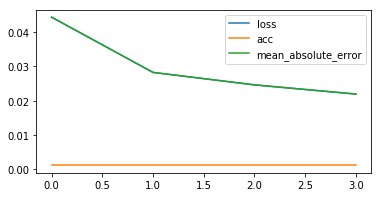

In [12]:
def _fit_model_(model,train_generator,model_params=None,epochs=None,callbacks=None,verbose=2,workers=3):
    import bs_ds as bs
    import functions_combined_BEST as ji
    from IPython.display import display

    quiet_command = ji.quiet_mode(True,True,True)
    exec(quiet_command)
    
    if model_params is None:
        model_params={}
    model_params['fit_params'] = {'epochs':epochs}#,'callbacks':callbacks}

    # Instantiating clock timer
    clock = bs.Clock()

    print('---'*20)
    print('\tFITTING MODEL:')
    print('---'*20,'\n')     
    
    # start the timer
    clock.tic('')

    # Fit the model
    fit_params = model_params['fit_params']
    if callbacks is None:
        
        history = model.fit_generator(train_generator,epochs=fit_params['epochs'], 
                                       verbose=2, use_multiprocessing=True, workers=3)
    else:
        
        history = model.fit_generator(train_generator,epochs=fit_params['epochs'],
                                       callbacks=callbacks,
                                       verbose=2,use_multiprocessing=True, workers=3)
    # model_results = model.history.history
    clock.toc('')
    
    return model,model_params,history
#########################################################################################
# Fit keras model to train_generator

model1,model_params,history =_fit_model_(model1,train_generator,
                                          model_params=model_params,
                                          epochs=4,callbacks=callbacks)

# Get results from model.evaluate_generator()
eval_results = ji.evaluate_model_plot_history(model1, train_generator, test_generator)

In [13]:
### PREFER NEW WAY - GET DF_MODEL FIRST THEN GET EVALUATE_REGRESSION INFORMATION?
## Get true vs pred data as a dataframe and iplot
df_model1 = ji.get_model_preds_df(model1, test_generator=test_generator,
                                  true_train_series = df_train['price'],
                                  true_test_series = df_test['price'],
                                  model_params=model_params,
                                  preds_from_gen=True, 
                                  preds_from_train_preds=True, 
                                  preds_from_test_preds=True,
                                 inverse_tf=True,iplot=True)

# Get evaluation metrics
regr_evals = ji.get_evaluate_regression_dict(df_model1,metrics=['r2', 'mae', 'U'],
                                             show_results_df=True, return_as_df=True)


# Compare predictions if predictions timebins shifted
df_results, df_shifted =\
ji.compare_eval_metrics_for_shifts(df_model1['true_from_gen'], df_model1['pred_from_gen'],
                                   shift_list=np.arange(-4,4,1),
                                   display_results=True, display_U_info=False,
                                   return_shifted_df=True, return_results=True)

28 28 28
Removed i_.
Using all columns...


,R²,MAE,U
Prediction Source,,,
from_gen,0.608,0.256,1.321
from_test_preds,-12.649,2.104,7.732
from_train_preds,-6.748,1.936,8.447


,R²,RMSE,U
Pred Shifted,,,
-4,0.584,0.364,0.95
-3,0.762,0.288,0.793
-2,0.904,0.186,0.604
-1,0.864,0.226,0.753
0,0.608,0.388,1.321
1,0.14,0.508,1.736
2,-0.406,0.591,2.468
3,-0.404,0.599,2.543


,U
# of Bins Shifted,
-4,0.949575
-3,0.793315
-2,0.603571
-1,0.753335
0,1.32073
1,1.73641
2,2.46761
3,2.54346


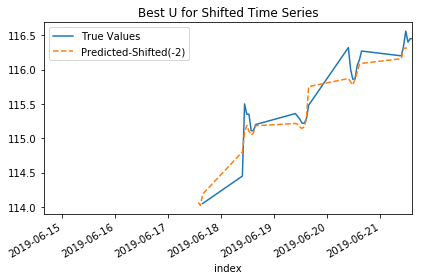

In [14]:
#? ## GET SHIFTED RESULTS FOR PREDS FROM GENERATOR
df_shifted = jik.compare_u_for_shifts(df_model1['true_from_gen'],df_model1['pred_from_gen'],
                        shift_list=np.arange(-4,4,1),
                        plot_all=False, plot_best=True,
                        color_coded=True,return_results=False,
                                     return_shifted_df=True)

,U
# of Bins Shifted,
-4,7.7632
-3,7.95222
-2,8.13129
-1,8.34628
0,8.55464
1,8.43717
2,8.31965
3,8.20209


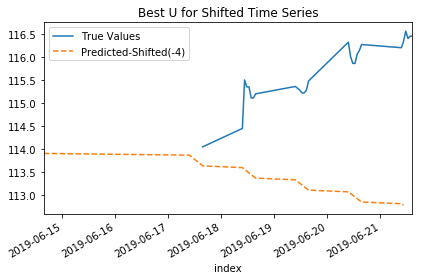

In [15]:
#? ## GET SHIFTED RESULTS FOR PREDS FROM TRAIN PREDS
df_shifted2 = jik.compare_u_for_shifts(df_model1['true_from_gen'],df_model1['pred_from_train_preds'],
                        shift_list=np.arange(-4,4,1),
                        plot_all=False, plot_best=True,
                        color_coded=True,return_results=False,
                                     return_shifted_df=True)
# res_df = ji.compare_time_shifted_model(df_model1,)

In [18]:
ji.save_model_weights_params(model1,model_params=model_params,
                             filename_prefix='models/model1', auto_increment_name=True,
                             auto_filename_suffix=True, suffix_time_format='%m-%d-%y_%I%M%p',
                             save_model_layer_config_xlsx=True)

Model saved as models/model1_08-06-19_0153pm.json
Weights saved as models/model1_08-06-19_0153pm.json_weights.h5


('models/model1_08-06-19_0153pm',
 'models/model1_08-06-19_0153pm.json_weights.h5')

## MODEL 2

## Model 1


In [158]:
## IMPORT PACKAGES
from bs_ds.imports import *

import functions_combined_BEST as ji
import my_keras_functions as jik

# Import some functions directly
from functions_combined_BEST import ihelp, ihelp_menu, reload


# Import plotly and cufflinks for iplots
import plotly
import cufflinks as cf
cf.go_offline()

# Reload modules in case files have been updated
reload(jik)
reload(ji)

# Suppress warnings
ji.quiet_mode()

"import warnings\nwarnings.filterwarnings('ignore')\nimport os\nos.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'"

In [2]:
# Load stock_df data from functions detailed above

"""NOTE: current processed filename ready for modeling is: processed_datafile"""
processed_datafile = '_stock_df_with_technical_indicators.csv'

# LOAD IN FULL STOCK DATASET 
full_df = ji.load_processed_stock_data()

# SELECT DESIRED COLUMNS
stock_df = full_df[[
    'price','ma7','ma21','26ema','12ema','MACD',
    '20sd','upper_band','lower_band','ema','momentum','filled_timebin'
]].copy()

# print(stock_df.index.freq)
display(stock_df.head(3))
fig = ji.plotly_time_series(stock_df['price'])

>> File found. Loading _stock_df_with_technical_indicators.csv
DatetimeIndex(['2016-12-29 15:30:00', '2019-06-21 15:30:00'], dtype='datetime64[ns]', name='date_time_index', freq=None) <CustomBusinessHour: CBH=09:30-16:30>


,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,filled_timebin
date_time_index,,,,,,,,,,,,
2016-12-29 15:30:00,96.27,96.864898,96.277007,96.573856,96.730494,0.156639,1.002051,98.281110,94.272904,96.263988,89.27,False
2016-12-30 09:30:00,96.38,96.850204,96.293537,96.571218,96.721997,0.150779,0.980655,98.254848,94.332227,96.341329,89.38,False
2016-12-30 10:30:00,96.21,96.831633,96.307891,96.566317,96.709593,0.143275,0.959724,98.227340,94.388442,96.253776,89.21,False


In [3]:
## Define data parameters for train_test_split 
model_params={}
model_params['data_params'] = ji.def_data_params(stock_df,
                                                 num_test_days=5, num_train_days=365, 
                                                 days_for_x_window=1, verbose=0)

###### TRAIN TEST SPLIT BY NUMBER OF DAYS ######
dp = model_params['data_params']
df_train, df_test = ji.train_test_split_by_last_days(stock_df,
                                                     periods_per_day = dp['periods_per_day'], 
                                                     num_test_days   =  dp['num_test_days'],
                                                     num_train_days  =  dp['num_train_days'],
                                                     verbose=0, iplot=False)

display(df_train.head(2).style.set_caption('df_train - pre-scaling'))
# ji.display_dict_dropdown(model_params)

###### RESCALE DATA USING MinMaxScalers FIT ON TRAINING DATA's COLUMNS ######
scaler_library, df_train, model_params = ji.make_scaler_library(df_train, 
                                                                transform=True,
                                                                model_params=model_params,
                                                                verbose=2)

df_test = ji.transform_cols_from_library(df_test,col_list=None,col_scaler_dict=scaler_library,
                                                      scaler_library=scaler_library,inverse=False)

# Show transformed dataset
display( df_train.head(2).round(3).style.set_caption('training data - scaled'))#,
#         df_test.head(2).round(3).style.set_caption('test data'))

# Create timeseries generators
train_generator, test_generator, model_params =\
    ji.make_train_test_series_gens( df_train['price'], df_test['price'],
                                   n_features=1,batch_size=1, model_params=model_params,
                                   verbose=0)

ji.display_dict_dropdown(model_params)

# # ji.display_dict_dropdown(model_params)
# funcs_make_model = ['make_train_test_series_gens','def_callbacks_and_params',
#                   'def_compile_params_optimizer','make_model1'] 
# ihelp_menu(funcs_make_model)

,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,filled_timebin
date_time_index,,,,,,,,,,,,
2018-01-22 09:30:00,114.34,113.986,112.042,111.798,113.236,1.43854,1.55789,115.158,108.927,114.382,107.34,False
2018-01-22 10:30:00,115.03,114.029,112.075,111.833,113.278,1.44542,1.56858,115.212,108.938,114.814,108.03,False


These columns were excluded due to incompatible dtypes.
['filled_timebin']



,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,filled_timebin
date_time_index,,,,,,,,,,,,
2018-01-22 09:30:00,0.877,0.878,0.763,0.75,0.828,0.94,0.254,0.669,0.738,0.878,0.877,False
2018-01-22 10:30:00,0.906,0.88,0.765,0.752,0.831,0.942,0.256,0.673,0.738,0.896,0.906,False


Using TensorFlow backend.


------------ Dictionary Contents ------------


interactive(children=(Dropdown(description='dict_to_display', options={'data_params': {'num_test_days': 5, 'nu…

In [4]:
def _def_callbacks_and_params_(model_params=None,loss_function='mae',checkpoint_mode='min',filepath=None,
                             stop_mode='min',patience=1,min_delta=.001,verbose=1):
    import functions_combined_BEST as ji
    

            ########## Define loss function and callback params ##########
    callback_params ={}
    callback_params['custom_loss_function'] = loss_function
    callback_params['ModelCheckpoint'] = {'monitor': loss_function, 'mode':checkpoint_mode}
    callback_params['EarlyStopping'] = {'monitor':loss_function, 'mode':stop_mode, 
                                        'patience':patience, 'min_delta':min_delta}

    # CREATING CALLBACKS
    from keras import callbacks

    if filepath is None:
        filepath = f"models/checkpoints/model1_weights_{ji.auto_filename_time(prefix=None)}.hdf5"

    if 'my_rmse' in loss_function:
        import functions_combined_BEST as ji
        loss_function = ji.my_rmse
#         my_rmse=my_rmse
#         loss_function = my_rmse

    # Create ModelCheckPoint
    fun_params=callback_params['ModelCheckpoint']
    checkpoint = callbacks.ModelCheckpoint(filepath=filepath, monitor=loss_function, mode=fun_params['mode'],
                                           save_best_only=True, verbose=verbose)
    # Create EarlyStopping
    fun_params=callback_params['EarlyStopping']
    early_stop = callbacks.EarlyStopping(monitor=loss_function, mode=fun_params['mode'], patience=fun_params['patience'],
                                         min_delta=fun_params['min_delta'],verbose=verbose)
    callbacks = [checkpoint,early_stop]

    if model_params is None:
        model_params=callback_params
    else:
        model_params['callbacks'] = callback_params
    return callbacks, model_params
#########################################################################################
# Create ModelCheckpoint and early Stopping callbacks
callbacks, model_params = \
    _def_callbacks_and_params_(model_params, loss_function='my_rmse',
                               checkpoint_mode='min', stop_mode = 'min',
                                patience=1, min_delta=0.001, verbose=1)

#########################################################################################
def _def_compile_params_optimizer_(loss='my_rmse',metrics=['acc','my_rmse'],optimizer='optimizers.Nadam()',model_params=None):
    ####### Specify additional model parameters
    from keras import optimizers
         
    compile_params={}
    compile_params['loss']= loss#{'my_rmse':my_rmse}
    compile_params['metrics'] = metrics#['acc',my_rmse]
    
    if type(optimizer) is str:
        optimizer_name = optimizer
        optimizer = eval(optimizer_name)
    else:
        optimizer_name = optimizer.__class__().__str__()
        
    compile_params['optimizer'] = optimizer
    compile_params['optimizer_name'] = optimizer_name#'optimizers.Nadam()'

    if model_params is not None:
        model_params['compile_params'] = compile_params
    else:
        model_params=compile_params
    
    return model_params
#########################################################################################
# Add compiler parameters to model_params for func make_model1(model_params)
model_params = _def_compile_params_optimizer_(
    loss='my_rmse', metrics=['acc','mae'],
    optimizer='optimizers.Nadam()', model_params=model_params)

ji.display_dict_dropdown(model_params)

Instructions for updating:
Colocations handled automatically by placer.
------------ Dictionary Contents ------------


interactive(children=(Dropdown(description='dict_to_display', options={'data_params': {'num_test_days': 5, 'nu…

In [5]:
# Create keras model from model_params
def _make_model1_(model_params, summary=True):
    from keras.models import Sequential
    from keras.layers import Bidirectional, Dense, LSTM, Dropout
    from IPython.display import display
    from keras.regularizers import l2

    # Specifying input shape (size of samples, rank of samples?)
    n_input = model_params['input_params']['n_input']
    n_features = model_params['input_params']['n_features']
    print(f'input shape: ({n_input},{n_features}')
    input_shape=(n_input, n_features)
    
    # Create model architecture
    model = Sequential()
    model.add(LSTM(units=50, input_shape =input_shape,return_sequences=True))#,  kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01),
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(1))

    # load compile params and compile
    comp_params = model_params['compile_params']
    # metrics = comp_params['metrics']
    loss=comp_params['loss']
    metrics=comp_params['metrics']
    
    if 'my_rmse' in loss or 'my_rmse' in metrics:

        def check_loss_metrics_for_my_rmse(loss,metrics):
            metric_function = metrics
            loss_function = loss
            
            import functions_combined_BEST as ji
            for i,idx in enumerate(metrics):
                if 'my_rmse' in metrics[i]:
                    metric_function[i]=ji.my_rmse
            
            if 'my_rmse' in loss:
                loss_function=ji.my_rmse
                
            return loss_function, metric_function
        
        loss_function,metric_function = check_loss_metrics_for_my_rmse(loss,metrics)
        
    model.compile(loss=loss_function, metrics=metric_function,
                  optimizer=comp_params['optimizer'])##eval(comp_params['optimizer']), metrics=metrics)#optimizer=optimizers.Nadam()
    

    if summary is True:
        display(model.summary())
        
#     if return_params:
#         model_params['compile_params']['loss'] = loss_str
#         model_params['compile_params']['metrics'] = metrics_str
#         return model, model_params
    return model
#########################################################################################

model1=_make_model1_(model_params)

# Display all parameters used to create model
ji.display_dict_dropdown(model_params,title='Parameters for Keras Model')

input shape: (7,1
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


None

------------ Parameters for Keras Model ------------


interactive(children=(Dropdown(description='dict_to_display', options={'data_params': {'num_test_days': 5, 'nu…

------------------------------------------------------------
	FITTING MODEL:
------------------------------------------------------------ 

--- CLOCK STARTED @:    08/05/19 - 06:15:05 PM           Label:            --- 
Epoch 1/2
 - 37s - loss: 0.0150 - acc: 0.0012 - mean_absolute_error: 0.0150
Epoch 2/2
 - 37s - loss: 0.0151 - acc: 0.0012 - mean_absolute_error: 0.0151
--- TOTAL DURATION   =  1 min, 13.690 sec --- 


Lap #,Start Time,Duration,Label
TOTAL,08/05/19 - 06:15:05 PM,"1 min, 13.690 sec",




------------------------------------------------------------------------------------
	EVALUATE MODEL:
------------------------------------------------------------------------------------


,Training Data,Test Data
acc,0.001177,0.00000
loss,0.025584,0.04055
mean_absolute_error,0.025584,0.04055


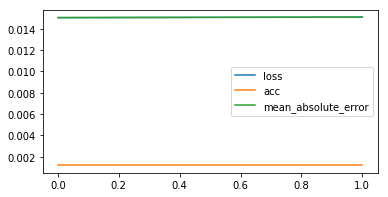

28 28 28
Removed i_.
Using all columns...


In [347]:
def _fit_model_(model,train_generator,model_params=None,epochs=2,callbacks=None,verbose=2,workers=3):
    import bs_ds as bs
    import functions_combined_BEST as ji
    from IPython.display import display

    quiet_command = ji.quiet_mode(True,True,True)
    exec(quiet_command)
    
    if model_params is None:
        model_params={}
    model_params['fit_params'] = {'epochs':epochs}#,'callbacks':callbacks}

    # Instantiating clock timer
    clock = bs.Clock()

    print('---'*20)
    print('\tFITTING MODEL:')
    print('---'*20,'\n')     
    
    # start the timer
    clock.tic('')

    # Fit the model
    fit_params = model_params['fit_params']
    if callbacks is None:
        
        history = model.fit_generator(train_generator,epochs=fit_params['epochs'], 
                                       verbose=2, use_multiprocessing=True, workers=3)
    else:
        
        history = model.fit_generator(train_generator,epochs=fit_params['epochs'],
                                       callbacks=callbacks,
                                       verbose=2,use_multiprocessing=True, workers=3)
    # model_results = model.history.history
    clock.toc('')
    
    return model,model_params,history
#########################################################################################
# Fit keras model to train_generator

model1,model_params,history =_fit_model_(model1,train_generator,
                                          model_params=model_params,
                                          epochs=2,callbacks=callbacks)

# Get results from model.evaluate_generator()
eval_results = ji.evaluate_model_plot_history(model1, train_generator, test_generator)


### PREFER NEW WAY - GET DF_MODEL FIRST THEN GET EVALUATE_REGRESSION INFORMATION?
# # # Get true vs pred data as a dataframe
# df_model1 = ji.get_model_preds_df(model1, test_generator=test_generator,
#                                   true_train_series = df_train['price'],
#                                   true_test_series = df_test['price'],model_params=model_params,
#                                   preds_from_gen=True, preds_from_train_preds=True, preds_from_test_preds=True,
#                                  inverse_tf=True,iplot=False)
# # Get true vs pred data as a dataframe
df_model1 = ji.get_model_preds_df(model1, test_generator=test_generator,
                                  true_train_series = df_train['price'],
                                  true_test_series = df_test['price'],model_params=model_params,
                                  preds_from_gen=True, preds_from_train_preds=True, preds_from_test_preds=False,
                                 inverse_tf=True,iplot=False)

regr_evals = ji.get_evaluate_regression_dict(df_model1,show_results_df=True,return_as_df=True)

df_results, df_shifted =\
ji.compare_eval_metrics_for_shifts(df_model1['true_from_gen'],df_model1['pred_from_gen'],
                                   shift_list=np.arange(-4,4,1),display_results=True,
                                   display_U_info=False, return_shifted_df=True, return_results=True)

In [355]:
# reload(jik)
# reload(ji)
# ji.plot_best_shift(df_model1, df_results, true_colname='true_from_gen',pred_colname='pred_from_gen')

In [346]:
df_results, df_shifted =\
ji.compare_eval_metrics_for_shifts(df_model1['true_from_gen'],df_model1['pred_from_gen'],
                                   shift_list=np.arange(-4,4,1),
                                   return_shifted_df=True,
                                   return_results=True,display_U_info=False, display_results=True)

,R²,RMSE,U
Pred Shifted,,,
-4,0.573,0.369,1.067
-3,0.637,0.355,1.005
-2,0.694,0.332,1.082
-1,0.733,0.316,1.045
0,0.448,0.461,1.564
1,-0.17,0.593,2.018
2,-0.895,0.686,2.922
3,-0.949,0.706,3.046


In [356]:
# print('Predictions from Generator\n','---'*20)
# df_res1, df_shifted1 = jik.compare_u_for_shifts(df_model1['true_from_gen'],df_model1['pred_from_gen'],
#                         shift_list=np.arange(-4,4,1),
#                         plot_all=False, plot_best=True,
#                         color_coded=True,return_results=True,
#                                      return_shifted_df=True)

# print('Predictions from Training Data Predictions\n','---'*20)

# df_res2, df_shifted2 = jik.compare_u_for_shifts(df_model1['true_from_gen'],df_model1['pred_from_train_preds'],
#                         shift_list=np.arange(-4,4,1),
#                         plot_all=False, plot_best=True,
#                         color_coded=True,return_results=True,
#                                      return_shifted_df=True)
# # res_df = ji.compare_time_shifted_model(df_model1,)

# EARLIER MODELING

In [ ]:
from functions_combined_BEST import *

In [ ]:
# import pandas as pd 
# import numpy as np
# import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')

# def quick_table(tuples, col_names=None, caption =None,display_df=True):
#     """Accepts a bigram output tuple of tuples and makes captioned table."""
#     import pandas as pd
#     from IPython.display import display
#     if col_names == None:
    
#         df = pd.DataFrame.from_records(tuples)
        
#     else:
        
#         df = pd.DataFrame.from_records(tuples,columns=col_names)
#         dfs = df.style.set_caption(caption)
        
#         if display_df == True:
#             display(dfs)
            
#     return df

# def compare_word_cloud(text1,label1,text2,label2):
#     """Compares the wordclouds from 2 sets of texts"""
#     from wordcloud import WordCloud
#     import matplotlib.pyplot as plt

#     wordcloud1 = WordCloud(max_font_size=80, max_words=200, background_color='white').generate(' '.join(text1))
#     wordcloud2 = WordCloud(max_font_size=80, max_words=200, background_color='white').generate(' '.join(text2))


#     fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,15))
#     ax[0].imshow(wordcloud1, interpolation='bilinear')
#     ax[0].set_aspect(1.5)
#     ax[0].axis("off")
#     ax[0].set_title(label1, fontsize=20)

#     ax[1].imshow(wordcloud2, interpolation='bilinear')
#     ax[1].set_aspect(1.5)
#     ax[1].axis("off")
#     ax[1].set_title(label2, fontsize=20)

#     fig.tight_layout()
#     return fig,ax

# # Define get_tags_ats to accept a list of text entries and return all found tags and ats as 2 series/lists
# def get_tags_ats(text_to_search,exp_tag = r'(#\w*)',exp_at = r'(@\w*)', output='series',show_counts=False):
#     """Accepts a list of text entries to search, and a regex for tags, and a regex for @'s.
#     Joins all entries in the list of text and then re.findsall() for both expressions.
#     Returns a series of found_tags and a series of found_ats.'"""
#     import re
#     import pandas as pd
#     # Create a single long joined-list of strings
#     text_to_search_combined = ' '.join(text_to_search)
        
#     # print(len(text_to_search_combined), len(text_to_search_list))
#     found_tags = re.findall(exp_tag, text_to_search_combined)
#     found_ats = re.findall(exp_at, text_to_search_combined)
    
#     if output.lower() == 'series':
#         found_tags = pd.Series(found_tags, name='tags')
#         found_ats = pd.Series(found_ats, name='ats')
        
#         if show_counts==True:
#             print(f'\t{found_tags.name}:\n{found_tags.value_counts()} \n\n\t{found_ats.name}:\n{found_ats.value_counts()}')
                
#     if (output.lower() != 'series') & (show_counts==True):
#         raise Exception('output must be set to "series" in order to show_counts')
                       
#     return found_tags, found_ats


# def clean_text(series,is_tokens=False,return_tokens=False, urls=True, hashtags=True, mentions=True, remove_stopwords=True, verbose=False):
#     """Accepts a series/df['column'] and tokenizes, removes urls, hasthtags, and @s using regex before tokenizing and removing stopwrods"""
#     import pandas as pd
#     import re, nltk
#     from nltk.corpus import stopwords
    
#     series_cleaned=series.copy()
    
#     # Remove URLS
#     if urls==True:
#         urls = re.compile(r"(http[s]?://\w*\.\w*/+\w+)")
#         series_cleaned = series_cleaned.apply(lambda x: urls.sub(' ', x))
            
#         if verbose==True:
#             print('URLs removed...')
            
#     # Remove hashtags
#     if hashtags==True:
#         hashtags = re.compile(r'(\#\w*)')
#         series_cleaned = series_cleaned.apply(lambda x: hashtags.sub(' ', x))
        
#         if verbose==True:
#             print('Hashtags removed...')
    
#     # Remove mentions
#     if mentions==True:
#         mentions = re.compile(r'(\@\w*)')
#         series_cleaned = series_cleaned.apply(lambda x: mentions.sub(' ',x))

#         if verbose==True:
#             print('Mentions removed...')
    
    
#     # Regexp_tokenize stopped words (to keep contractions)
#     if is_tokens==False:
#         pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
#         series_cleaned = series_cleaned.apply(lambda x: nltk.regexp_tokenize(x,pattern))
#         if verbose==True:
#             print('Text regexp_tokenized...\n')
    
    
#     # Filter Out Stopwords
#     stopwords_list = []
#     from nltk.corpus import stopwords
#     import string
    
#     # Generate Stopwords List
#     stopwords_list = stopwords.words('english')
#     stopwords_list += list(string.punctuation)
#     stopwords_list += ['http','https','...','``','co','“','’','‘','”',
#                        'rt',"n't","''","RT",'u','s',"'s",'?']#,'@','#']
#     stopwords_list += [0,1,2,3,4,5,6,7,8,9]
#     stopwords_list +=['RT','rt',';']
     
#     if remove_stopwords==True:
#         series_cleaned = series_cleaned.apply(lambda x: [w.lower() for w in x if w.lower() not in stopwords_list])
#         # for s in range(len(series_cleaned)):
#         #     text =[]
#         #     text_stopped = []
#         #     text = series_cleaned[s]
#         #     text_stopped = [x.lower() for x in text if x.lower() not in stopwords_list]
#         #     series_cleaned[s]= text_stopped
        
#         if verbose==True:
#             print('Stopwords removed...')
       
#     if return_tokens==False:
#         series_cleaned = series_cleaned.apply(lambda x: ' '.join(x))
    
#     print('\n')
#     return series_cleaned

# def train_test_val_split(X,y,test_size=0.20,val_size=0.1):
#     """Performs 2 successive train_test_splits to produce a training, testing, and validation dataset"""
#     from sklearn.model_selection import train_test_split

#     first_split_size = test_size + val_size
#     second_split_size = val_size/(test_size + val_size)

#     X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=first_split_size)

#     X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=second_split_size)

#     return X_train, X_test, X_val, y_train, y_test, y_val


# def plot_keras_history(history):
#     """Plots the history['acc','val','val_acc','val_loss']"""
#     import matplotlib.pyplot as plt
#     acc = history.history['acc']
#     loss = history.history['loss']
#     val_acc = history.history['val_acc']
#     val_loss = history.history['val_loss']
#     x = range(1,len(acc)+1)
    
#     fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(6,8))
#     ax[0].plot(x, acc,'b',label='Training Acc')
#     ax[0].plot(x, val_acc,'r',label='Validation Acc')
#     ax[0].legend()
#     ax[1].plot(x, loss,'b',label='Training Loss')
#     ax[1].plot(x, val_loss, 'r', label='Validation Loss')
#     ax[1].legend()
#     plt.show()
#     return fig, ax


# def plot_auc_roc_curve(y_test, y_test_pred):
#     """ Takes y_test and y_test_pred from a ML model and plots the AUC-ROC curve."""
#     from sklearn.metrics import confusion_matrix
#     from sklearn.metrics import roc_auc_score, roc_curve
#     import matplotlib.pyplot as plt
#     auc = roc_auc_score(y_test, y_test_pred[:,1])

#     FPr, TPr, _  = roc_curve(y_test, y_test_pred[:,1])
#     plt.plot(FPr, TPr,label=f"AUC for CatboostClassifier:\n{round(auc,2)}" )

#     plt.plot([0, 1], [0, 1],  lw=2,linestyle='--')
#     plt.xlim([-0.01, 1.0])
#     plt.ylim([0.0, 1.05])

#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic (ROC) Curve')
#     plt.legend(loc="lower right")
#     plt.show()



# def display_random_tweets(df_tokenize,n=5 ,display_cols=['content','text_for_vectors','tokens'], group_labels=[],verbose=True):
#     """Takes df_tokenize['text_for_vectors']"""
#     import numpy as np
#     import pandas as pd 
#     from IPython.display import display
#     if len(group_labels)==0:

#         group_labels = display_cols

    
#     random_tweets={}
#     # Randomly pick n indices to display from specified col
#     idx = np.random.choice(range(len(df_tokenize)), n)
    
#     for i in range(len(display_cols)):
        
#         group_name = str(group_labels[i])
#         random_tweets[group_name] ={}

#         # Select column data
#         df_col = df_tokenize[display_cols[i]]
        

#         tweet_group = {}
#         tweet_group['index'] = idx
        
#         chosen_tweets = df_col[idx]
#         tweet_group['text'] = chosen_tweets

#         # print(chosen_tweets)
#         if verbose>0:
#             with pd.option_context('max_colwidth',300):
#                 df_display = pd.DataFrame.from_dict(tweet_group)
#                 display(df_display.style.set_caption(f'Group: {group_name}'))


#         random_tweets[group_name] = tweet_group
        
#         # if verbose>0:
              
#         #     for group,data in random_tweets.items():
#         #         print(f'\n\nRandom Tweet for {group:>.{300}}:\n{"---"*20}')

#         #         df = random_tweets[group]
#         #         display(df)
#     if verbose==0:
#         return random_tweets
#     else:
#         return


# def reload(mod):
#     """Reloads the module from file."""
#     from importlib import reload
#     import sys
#     print(f'Reloading...')
#     return  reload(mod)


# def process_df_full(df_full, raw_col='content_raw', fill_content_col='content',force=False):
#     """Accepts df_full, which contains the raw tweets to process, the raw_col name, the column to fill.
#     If force=False, returns error if the fill_content_col already exists.
#     Processing Workflow:1) Create has_RT, starts_RT columns. 2) Creates [fill_content_col,`content_min_clean`] cols after removing 'RT @mention:' and urls.
#     3) Removes hashtags from fill_content_col and saves hashtags in new col. 4) Removes mentions from fill_content_col and saves to new column."""
#     import re
#     import pandas as pd
    
#     if force==False:
#         if fill_content_col in df_full.columns:
#             raise Exception(f'{fill_content_col} already exists. To overwrite, set force=True.')


#     # # create 'content_raw' column from 'content'
#     # df_full[fill_content_col] = df_full['content'].copy()


#     # Add has_RT and starts_RT columns
#     # Creating columns for tweets that `has_RT` or `starts_RT`
#     df_full['has_RT']=df_full[raw_col].str.contains('RT')
#     df_full['starts_RT']=df_full[raw_col].str.contains('^RT')


#     ## FIRST REMOVE THE RT HEADERS

#     # Remove `RT @Mentions` FIRST:
#     re_RT = re.compile(r'RT [@]?\w*:')

#     # raw_col =  'content_raw'
#     check_content_col =raw_col
#     fill_content_col = fill_content_col

#     df_full['content_starts_RT'] = df_full[check_content_col].apply(lambda x: re_RT.findall(x))
#     df_full[fill_content_col] =  df_full[check_content_col].apply(lambda x: re_RT.sub(' ',x))


#     ## SECOND REMOVE URLS
#     # Remove urls with regex
#     urls = re.compile(r"(http[s]?://\w*\.\w*/+\w+)")

#     check_content_col = fill_content_col
#     fill_content_col = fill_content_col

#     # df_full['content_urls'] = df_full[check_content_col].apply(lambda x: urls.findall(x))
#     df_full[fill_content_col] =  df_full[check_content_col].apply(lambda x: urls.sub(' ',x))

#     ## SAVE THIS MINIMALLY CLEANED CONTENT AS 'content_min_clean'
#     df_full['content_min_clean'] =  df_full[fill_content_col]




#     ## REMOVE AND SAVE HASHTAGS, MENTIONS
#     # Remove and save Hashtags
#     hashtags = re.compile(r'\#\w*')

#     check_content_col = fill_content_col
#     fill_content_col = fill_content_col

#     df_full['content_hashtags'] =  df_full[check_content_col].apply(lambda x: hashtags.findall(x))
#     df_full[fill_content_col] =  df_full[check_content_col].apply(lambda x: hashtags.sub(' ',x))


#     # Remove and save mentions (@)'s
#     mentions = re.compile(r'\@\w*')

#     check_content_col = fill_content_col
#     fill_content_col = fill_content_col

#     df_full['content_mentions'] =  df_full[check_content_col].apply(lambda x: mentions.findall(x))
#     df_full[fill_content_col] =  df_full[check_content_col].apply(lambda x: mentions.sub(' ',x))

#     return df_full



# def load_orig_dataset(root_dir = 'russian-troll-tweets/', ext='.csv'):
#     """Accepts a root_dir, finds all files that end with ext and loads into a dataframe."""
#     import os
#     import pandas as pd
#     # root_dir = 'russian-troll-tweets/'
#     # os.listdir('russian-troll-tweets/')
#     filelist = [os.path.join(root_dir,file) for file in os.listdir(root_dir) if file.endswith(ext)]
#     print(f'Loading {len(filelist)} files into dataframe...')
#         # Vertically concatenate 
#     df = pd.DataFrame()
#     for file in filelist:
#         df_new = pd.read_csv(file)
#         df = pd.concat([df,df_new], axis=0)
#     # df.info()

#     return df

# def ask_user_to_save(df, filename=None,encoding=None, ask=True, skip_saving=False, overwrite=False):
#     """Asks user to save df as filename. If no filename specified: filename ='saved_df.csv'
#     Set ask=False to save without asking."""
#     import os, warnings

#     if type(df)=='string':
#         raise Exception('First input must be the dataframe to be saved.')
#     if skip_saving==True:
#         return print(f'Since skip_loading=True, no file was save.')

#     if filename==None:
#         filename='saved_df.csv'
    
#     if ask==True:
#         ans = input('Would you like to save the df to a .csv?(y/n):')
#     else:
#         ans = 'y'
    
#     # If ans to save =='y'
#     if ans.lower()=='y':

#         # Check if the file already exists
#         if filename in os.listdir():
        
#             if overwrite==False:
#                 # raise Exception(f"{filename} already exists.")
#                 return warnings.warn(f"{filename} already exists.")

#             if overwrite==True:
#                 warnings.warn(f"Overwriting {filename}.")

#         df.to_csv(filename)
#         print(f'{filename} successfully saved.')
#     else:
#         print('Ok. No file was saved. ')
        

# def ask_user_to_load(filename, load_as_global = True ,ask=True, skip_loading=False, index_col=0, encoding=None):
#     """Asks user to save df as filename. If no filename specified: filename ='saved_df.csv'
#     Set ask=False to save without asking."""
#     import os
#     import pandas as pd

    
#     if skip_loading==True:
#         return print(f'Since skip_loading=True, no file was loaded.')
        

#     if ask==True:
#         ans = input('Would you like to load {filename} to a datafrane?(y/n):')

#     else:
#         ans = 'y'
        

#     # If ans to load =='y'
#     if ans.lower()=='y':
        
#         if load_as_global == True:
#             global df_
#             df_ = pd.read_csv(filename, encoding=encoding,index_col=index_col) 
#             print(f'{filename} loaded as global variable: "df_"')
#             pass
#         else:
#             df_ = pd.read_csv(filename, encoding=encoding,index_col=index_col) 
#             return df_
#     else:
#         return print('Ok. No file was loaded.')
        

# def run_all_checkpoint(skip=False):
#     ans = input('Continue running all?(y/n):')
#     if ans.lower()=='y':
#         return print('OK. Continuing to run...')
#     else:
#         raise Exception('User requested to stop running.')


# ## TO CHECK FOR STRINGS IN BOTH DATASETS:
# def check_dfs_for_exp_list(df_controls, df_trolls, list_of_exp_to_check):
#     df_resample = df_trolls
#     for exp in list_of_exp_to_check:
#     #     exp = '[Pp]eggy'
#         print(f'For {exp}:')
#         print(f"\tControl tweets: {len(df_controls.loc[df_controls['content_min_clean'].str.contains(exp)])}")
#         print(f"\tTroll tweets: {len(df_resample.loc[df_resample['content_min_clean'].str.contains(exp)])}\n")
              
# # list_of_exp_to_check = ['[Pp]eggy','[Mm]exico','nasty','impeachment','[mM]ueller']
# # check_dfs_for_exp_list(df_controls, df_resample, list_of_exp_to_check=list_of_exp_to_check)


# def get_group_texts_tokens(df_small, groupby_col='troll_tweet', group_dict={0:'controls',1:'trolls'}, column='content_stopped'):
#     from nltk import regexp_tokenize
#     pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
#     text_dict = {}
#     for k,v in group_dict.items():
#         group_text_temp = df_small.groupby(groupby_col).get_group(k)[column]
#         group_text_temp = ' '.join(group_text_temp)
#         group_tokens = regexp_tokenize(group_text_temp, pattern)
#         text_dict[v] = {}
#         text_dict[v]['tokens'] = group_tokens
#         text_dict[v]['text'] =  ' '.join(group_tokens)
            
#     print(f"{text_dict.keys()}:['tokens']|['text']")
#     return text_dict



# def check_df_groups_for_exp(df_full, list_of_exp_to_check, check_col='content_min_clean', groupby_col='troll_tweet', group_dict={0:'Control',1:'Troll'}):      
#     """Checks `check_col` column of input dataframe for expressions in list_of_exp_to_check and 
#     counts the # present for each group, defined by the groupby_col and groupdict. 
#     Returns a dataframe of counts."""
    
#     list_of_results = []      

#     header_list= ['Term']
#     [header_list.append(x) for x in group_dict.values()]
#     list_of_results.append(header_list)
    
#     for exp in list_of_exp_to_check:
#         curr_exp_list = [exp]
        
#         for k,v in group_dict.items():
#             df_group = df_full.groupby(groupby_col).get_group(k)
#             curr_group_count = len(df_group.loc[df_group[check_col].str.contains(exp)])
#             curr_exp_list.append(curr_group_count)
        
#         list_of_results.append(curr_exp_list)
        
#     df_results = bs.list2df(list_of_results, index_col='Term')
#     return df_results


# ###########################################################################

# def plot_fit_cloud(troll_cloud,contr_cloud,label1='Troll',label2='Control'):
#     import matplotlib.pyplot as plt
#     fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(18,18))

#     ax[0].imshow(troll_cloud, interpolation='gaussian')
#     # ax[0].set_aspect(1.5)
#     ax[0].axis("off")
#     ax[0].set_title(label1, fontsize=40)

#     ax[1].imshow(contr_cloud, interpolation='bilinear',)
#     # ax[1].set_aspect(1.5)
#     ax[1].axis("off")
#     ax[1].set_title(label2, fontsize=40)
#     plt.tight_layout()
#     return fig, ax
              
              
              

# ############### TIMESERIES TESTS AND VISUALS ###############

# def plot_time_series(stocks_df, freq=None, fill_method='ffill',figsize=(12,4)):
    
#     df = stocks_df.copy()
#     df.fillna(method=fill_method, inplace=True)
#     df.dropna(inplace=True)
    
#     if (df.index.freq==None) & (freq == None):
#         xlabels=f'Time'
    
#     elif (df.index.freq==None) & (freq != None):
#         df = df.asfreq(freq)
#         df.fillna(method=fill_method, inplace=True)
#         df.dropna(inplace=True)
#         xlabels=f'Time - Frequency = {freq}'

#     else:
#         xlabels=f'Time - Frequency = {df.index.freq}'
        
#     ylabels="Price"

#     raw_plot = df.plot(figsize=figsize)
#     raw_plot.set_title('Stock Bid Closing Price ')
#     raw_plot.set_ylabel(ylabels)
#     raw_plot.set_xlabel(xlabels)
    
    
# #################### TIMEINDEX FUNCTIONS #####################
# def get_day_window_size_from_freq(dataset):#, freq='CBH'):
    
#     if dataset.index.freq == custom_BH_freq():
#         return 7
    
#     if dataset.index.freq=='T':
#         day_window_size = 1440
#     elif dataset.index.freq=='BH':
#         day_window_size = 8
#     elif dataset.index.freq=='CBH':
#         day_window_size = 7
#     elif dataset.index.freq=='B':
#         day_window_size=1
#     elif dataset.index.freq=='D':
#         day_window_size=1
        
#     else:
#         raise Exception('dataset freq=None')
        
#     return day_window_size
    

# def custom_BH_freq():
#     import pandas as pd
#     CBH = pd.tseries.offsets.CustomBusinessHour(start='09:30',end='16:30')
#     return CBH
    
    
# def  set_timeindex_freq(ive_df, col_to_fill=None, freq='CBH',fill_method='ffill',
#                         verbose=3): #set_tz=True,
    
#     import pandas as pd
#     import numpy as np
    
    
#     if verbose>1:
#         # print(f"{'Index When:':>{10}}\t{'Freq:':>{20}}\t{'Index Start:':>{40}}\t{'Index End:':>{40}}")
#         print(f"{'Index When:'}\t{'Freq:'}\t{'Index Start'}\t\t{'Index End:'}")
#         print(f"Pre-Change\t{ive_df.index.freq}\t{ive_df.index[0]}\t{ive_df.index[-1]}")
        
    
#     if freq=='CBH':
#         freq=custom_BH_freq()
# #         start_idx = 
        
#     # Change frequency to freq
#     ive_df = ive_df.asfreq(freq,)#'min')
    
#     #     # Set timezone
#     #     if set_tz==True:
#     #         ive_df.tz_localize()
#     #         ive_df.index = ive_df.index.tz_convert('America/New_York')
    
#     # Report Success / Details
#     if verbose>1:
#         print(f"Post-Change\t{ive_df.index.freq}\t{ive_df.index[0]}\t{ive_df.index[-1]}")


#     ## FILL AND TRACK TIMEPOINTS WITH MISSING DATA    
    
#     # Helper Function for adding column to track the datapoints that were filled
#     def check_null_times(x):
#         import numpy as np
#         if np.isnan(x):
#             return True
#         else:
#             return False

#     ## CREATE A COLUMN TO TRACK ROWS TO BE FILLED
#     # If col_to_fill provided, use that column to create/judge ive_df['filled_timebin'] 
#     if col_to_fill!=None:
#         ive_df['filled_timebin'] = ive_df[col_to_fill].apply(lambda x: check_null_times(x))#True if ive_df.isna().any()
        
#     # if not provided, use all columns and sum results
#     elif col_to_fill == None:
#         # Prefill fol with 0's
#         ive_df['filled_timebin']=0
        
#         # loop through all columns and add results of check_null_times from each loop
#     for col in ive_df.columns:
#         if ive_df[col].dtypes=='float64':
#             #ive_df['filled_timebin'] = ive_df[target_col].apply(lambda x: check_null_times(x))#True if ive_df.isna().any()
#             curr_filled_timebin_col = ive_df[col].apply(lambda x: check_null_times(x))#True if ive_df.isna().any() 

#             # add results
#             ive_df['filled_timebin'] +=  curr_filled_timebin_col
            
#     ive_df['filled_timebin'] = ive_df['filled_timebin'] >0
            
#     ## FILL IN NULL VALUES
#     ive_df.fillna(method=fill_method, inplace=True)

#     # Report # filled
#     if verbose>0:
#         check_fill = ive_df.loc[ive_df['filled_timebin']>0]
#         print(f'\nFilled {len(check_fill==True)}# of rows using method {fill_method}')
    
#     # Report any remaning null values
#     if verbose>0:
#         res = ive_df.isna().sum()
#         if res.any():
#             print(f'Cols with Nulls:')
#             print(res[res>0])
#         else:
#             print('No Remaining Null Values')   
            
#     # display header
#     if verbose>2:
#         display(ive_df.head())
    
#     return ive_df


# # Helper Function for adding column to track the datapoints that were filled
# def check_null_times(x):
#     import numpy as np
#     if np.isnan(x):
#         return True
#     else:
#         return False
              
# ######## SEASONAL DECOMPOSITION    
# def plot_decomposition(TS, decomposition, figsize=(12,8),window_used=None):
#     """ Plot the original data and output decomposed components"""
    
#     # Gather the trend, seasonality and noise of decomposed object
#     trend = decomposition.trend
#     seasonal = decomposition.seasonal
#     residual = decomposition.resid

#     fontdict_axlabels = {'fontsize':12}#,'fontweight':'bold'}
    
#     # Plot gathered statistics
#     fig, ax = plt.subplots(nrows=4, ncols=1,figsize=figsize)
    
#     ylabel = 'Original'
#     ax[0].plot(np.log(TS), color="blue")
#     ax[0].set_ylabel(ylabel, fontdict=fontdict_axlabels)
    
#     ylabel = label='Trend'
#     ax[1].plot(trend, color="blue")
#     ax[1].set_ylabel(ylabel, fontdict=fontdict_axlabels)
    
#     ylabel='Seasonality'
#     ax[2].plot(seasonal, color="blue")
#     ax[2].set_ylabel(ylabel, fontdict=fontdict_axlabels)
    
#     ylabel='Residuals'
#     ax[3].plot(residual, color="blue")
#     ax[3].set_ylabel(ylabel, fontdict=fontdict_axlabels)
#     ax[3].set_xlabel('Time', fontdict=fontdict_axlabels)
    
#     # Add title with window 
#     if window_used == None:
#         plt.suptitle('Seasonal Decomposition', y=1.02)
#     else:
#         plt.suptitle(f'Seasonal Decomposition - Window={window_used}', y=1.02)
    
#     # Adjust aesthetics
#     plt.tight_layout()
    
#     return ax
    
    
# def seasonal_decompose_and_plot(ive_df,col='BidClose',freq='H',
#                           fill_method='ffill',window=144,
#                          model='multiplicative', two_sided=False,
#                                plot_components=True):##WIP:
#     """Perform seasonal_decompose from statsmodels.tsa.seasonal.
#     Plot Output Decomposed Components"""
#     import pandas as pd
#     import numpy as np
#     from statsmodels.tsa.seasonal import seasonal_decompose


#     # TS = ive_df['BidClose'].asfreq('BH')
#     TS = pd.DataFrame(ive_df[col])
#     TS = TS.asfreq(freq)
#     TS[TS==0]=np.nan
#     TS.fillna(method='ffill',inplace=True)

#     # Perform decomposition
#     decomposition = seasonal_decompose(np.log(TS),freq=window, model=model, two_sided=two_sided)
    
#     if plot_components==True:
#         ax = plot_decomposition(TS, decomposition, window_used=window)
    
#     return decomposition



# def stationarity_check(df, col='BidClose',freq=None, day_window_size='infer',
#                        days_in_rolling_window=5):
#     """From learn.co lesson: use ADFuller Test for Stationary and Plot"""
    
#     import matplotlib.pyplot as plt
#     TS = df[col].copy()
    
#     if freq==None:
#         freq=df.index.freq
        
#     else:        
#         TS = TS.asfreq(freq)
#         TS.fillna(method='ffill',inplace=True)
#         TS.dropna(inplace=True)
    
    
#     # Import adfuller
#     from statsmodels.tsa.stattools import adfuller
#     import pandas as pd
#     import numpy as np
    
#     # Calculate rolling statistics
#     if day_window_size=='infer':
#         day_window_size = get_day_window_size_from_freq(TS)
        
#     window = day_window_size*days_in_rolling_window
#     rolmean = TS.rolling(window = window, center = False).mean()
#     rolstd = TS.rolling(window = window, center = False).std()
    
#     # Perform the Dickey Fuller Test
#     dftest = adfuller(TS) # change the passengers column as required 
    
#     #Plot rolling statistics:
#     fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,4))
#     ax[0].set_title('Rolling Mean & Standard Deviation')

#     ax[0].plot(TS, color='blue',label='Original')
#     ax[0].plot(rolmean, color='red', label='Rolling Mean',alpha =0.6)
#     ax[1].plot(rolstd, color='black', label = 'Rolling Std')
#     ax[0].legend()
#     ax[1].legend()
# #     plt.show(block=False)
#     plt.tight_layout()
    
#     # Print Dickey-Fuller test results
#     print ('Results of Dickey-Fuller Test:')
#     print('\tIf p<.05 then timeseries IS stationary.')

#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)
    
#     return None
              
              
# ##################### DATASET LOADING FUNCTIONS #####################   
# def load_raw_stock_data_from_txt(filename='IVE_bidask1min.txt', 
#                                folderpath='data/',
#                                start_index = '2017-01-23',
#                                  clean=False,fill_method='ffill',
#                                  freq='CBH',verbose=2):
#     import pandas as pd
    
#     # Load in the text file and set headers
#     fullfilename= folderpath+filename
#     headers = ['Date','Time','BidOpen','BidHigh','BidLow','BidClose','AskOpen','AskHigh','AskLow','AskClose']
#     stock_df = pd.read_csv(fullfilename, names=headers,parse_dates=True)
    
#     # Create datetime index
#     date_time_index = stock_df['Date']+' '+stock_df['Time']
#     date_time_index = pd.to_datetime(date_time_index)
#     stock_df.index=date_time_index
    
#     # Select only the days after start_index
#     stock_df = stock_df[start_index:]
    
#     # Remove 0's from BidClose
#     if clean==True:
        
#         stock_df.loc[stock_df['BidClose']==0] = np.nan
#         stock_df['BidClose'].fillna(method=fill_method, inplace=True)
        
#         if verbose>0:
#             print(f"Number of 0 values:\n{len(stock_df.loc[stock_df['BidClose']==0])}")
#             print(f"Filling 0 values using method = {fill_method}")
            


                  
#     # call set_timeindex_freq to specify proper frequency
#     if freq!=None:
#         # Set the time index .
#         stock_df = set_timeindex_freq(stock_df, freq=freq, fill_method = fill_method, verbose=verbose)
                  
#     # Display feedback
#     if verbose>0:
#         display(stock_df.head())
#     if verbose>1:
#         print(stock_df.index)

#     return stock_df



# # def load_stock_df_from_csv(filename='ive_sp500_min_data_match_twitter_ts.csv',
# #                            folderpath='data/',
# #                           start_index = '2017-01-23', clean=False,freq='CBH',
# #                            fill_method='ffill',verbose=2):
# #     import os
# #     import pandas as pd

# #     #         check_for_google_drive()
        
# #     # Check if user provided folderpath to append to filename
# #     if len(folderpath)>0:
# #         fullfilename = folderpath+filename
# #     else:
# #         fullfilename=filename
        
# #     # load in csv by fullfilename
# #     stock_df = pd.read_csv(fullfilename,index_col=0, parse_dates=True)
# #     stock_df = stock_df[start_index:]
# # #     stock_df = set_timeindex_freq(stock_df,['BidClose'],freq=freq, fill_method=fill_method)
    
# #     if clean==True:
        
# #         if verbose>0:
# #             print(f"Number of 0 values:\n{len(stock_df.loc[stock_df['BidClose']==0])}")
# #             print(f"Filling 0 values using method = {fill_method}")
            
# #         stock_df.loc[stock_df['BidClose']==0] = np.nan
# #         stock_df['BidClose'].fillna(method=fill_method, inplace=True)
        
# #     if freq!=None:
# #         # Set the time index .
# #         stock_df = set_timeindex_freq(stock_df, freq=freq, fill_method = fill_method, verbose=verbose)
        

# #     # Display info depending on verbose level
# #     if verbose>0:
# #         display(stock_df.head())
    
# #     if verbose>1:
# #         print(stock_df.index)
        
# #     return stock_df   
                  
# def get_technical_indicators(dataset,make_price_from='BidClose'):
    

#     dataset['price'] = dataset[make_price_from].copy()
#     if dataset.index.freq == custom_BH_freq():
#         days = get_day_window_size_from_freq(dataset)#,freq='CBH')
#     else:
#         days = get_day_window_size_from_freq(dataset)
        
#     # Create 7 and 21 days Moving Average
#     dataset['ma7'] = dataset['price'].rolling(window=7*days).mean()
#     dataset['ma21'] = dataset['price'].rolling(window=21*days).mean()
    
#     # Create MACD
#     dataset['26ema'] = dataset['price'].ewm(span=26*days).mean()
# #     dataset['12ema'] = pd.ewma(dataset['price'], span=12)
#     dataset['12ema'] = dataset['price'].ewm(span=12*days).mean()

#     dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

#     # Create Bollinger Bands
# #     dataset['20sd'] = pd.stats.moments.rolling_std(dataset['price'],20)
#     dataset['20sd'] = dataset['price'].rolling(20*days).std()
#     dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
#     dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
#     # Create Exponential moving average
#     dataset['ema'] = dataset['price'].ewm(com=0.5).mean()
    
#     # Create Momentum
#     dataset['momentum'] = dataset['price']-days*1
    
#     return dataset

                  
# def plot_technical_indicators(dataset, last_days=90):
   
#     days = get_day_window_size_from_freq(dataset)
    
#     fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(10, 6), dpi=100)
# #     shape_0 = dataset.shape[0]
# #     xmacd_ = shape_0-(days*last_days)
    
#     dataset = dataset.iloc[-(days*last_days):, :]
#     x_ = range(3, dataset.shape[0])
#     x_ =list(dataset.index)
    
#     # Plot first subplot
#     ax[0].plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
#     ax[0].plot(dataset['price'],label='Closing Price', color='b')
#     ax[0].plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
#     ax[0].plot(dataset['upper_band'],label='Upper Band', color='c')
#     ax[0].plot(dataset['lower_band'],label='Lower Band', color='c')
#     ax[0].fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
#     ax[0].set_title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
#     ax[0].set_ylabel('USD')
#     ax[0].legend()

# #     shape_0 = dataset.shape[0]
# #     xmacd_ = shape_0-(days*last_days)
# #     # Plot second subplot
# #     ax[1].set_title('MACD')
# #     ax[1].plot(dataset['MACD'],label='MACD', linestyle='-.')
# #     ax[1].hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
# #     ax[1].hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
# #     ax[1].plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

# #     ax[1].legend()
#     plt.delaxes(ax[1])
#     plt.show()
    
# # plot_technical_indicators(stock_df)#.filter(regex='Bid'))  


In [ ]:
# def train_test_split_by_last_days(stock_df, periods_per_day=7,num_test_days = 90, num_train_days=180, plot=True):
#     """Takes the last num_test_days of the time index to use as testing data, and take shte num_Trian_days prior to that date
#     as the training data."""
#     # DETERMINING DAY TO USE TO SPLIT DATA INTO TRAIN AND TEST
#     day_freq = periods_per_day
#     start_train_day = stock_df.index[-1] - num_train_days*day_freq
#     last_day = stock_df.index[-1] - num_test_days*day_freq
#     print(f'Dates for Train Data:{start_train_day} : {last_day}.')
#     print(f'Dates for Test Data:{last_day} : {stock_df.index[-1]}.')
#     train_data = stock_df.loc[start_train_day:last_day]#,'price']
#     test_data = stock_df.loc[last_day:]#,'price']
#     print(f'Data split on index:{last_day}.')
#     print(f'train_data.shape:{train_data.shape}')
#     print(f'test_data.shape:{test_data.shape}')


#     if plot==True:
#         if 'price' in stock_df.columns:
#             plot_col ='price'
#         elif 'price_labels' in stock_df.columns:
#             plot_col = 'price_labels'
        
#         train_data[plot_col].plot(label='Training')
#         test_data[plot_col].plot(label='Test')
#         plt.title('Training and Test Data for S&P500')
#         plt.ylabel('Price')
#         plt.xlabel('Trading Date/Hour')
#         plt.legend();
    
#     return train_data, test_data

# # train_data, test_data = train_test_split_by_last_days(stock_df)

In [ ]:
# # display(stock_df.head())
# # df_stock_sca, scaler_library = make_scaler_library(stock_df,transform=True)
# # display(df_stock_sca.head())

# # df_stock_inv = transform_cols_from_library(df_stock_sca,scaler_library,inverse=True)
# # display(df_stock_inv.head())

# def make_X_y_timeseries_data(data,x_window = 35, verbose=2,as_array=True):
#     """Takes a Series and creates X_train, y_train where each element of X contains x_window # of timepoints
#     and y_train contains one single timepoint following X_train's timepoint"""
#     import numpy as np
#     import pandas as pd
                          
    
#     if any(data.isna()):
#         raise Exception('Function does not accept null values')
        
#     # Display info on data
#     if verbose>0:
#         print(f'Input Range: {np.min(data)} - {np.max(data)}')
#         print(f'Input Shape: {np.shape(data)}\n')

#     time_index_in = data.index
#     time_index = data.index[x_window:]
    
#     X_train, y_train = [], []
#     check_time_index = []
# #     headers = data.columns
#     # for every possible x_window:
#     for i in range(x_window, data.shape[0]):
#         check_time_index.append([data.index[i-x_window], data.index[i]])
#         # Append a list of the past x_window # of timepoints
#         X_train.append(data.iloc[i-x_window:i])#.values)
        
#         # Append the next single timepoint's data
#         y_train.append(data.iloc[i])#.values)
    
#     if as_array == True:
#         # Make X_train, y_train into arrays
#         X_train, y_train = np.array(X_train), np.array(y_train)
    

#     if verbose>0:
#         print(f'\nOutput Shape - X: {X_train.shape}')
#         print(f'Output Shape - y: {y_train.shape}')
#         print(f'\nTimeindex Shape: {np.shape(time_index)}\n\tRange: {time_index[0]}-{time_index[-1]}')
#         print(f'\tFrequency:',time_index.freq)
# #     print(time_index)
# #     print(check_time_index)
#     return X_train, y_train, time_index


# def make_df_timeseries_bins_by_column(df, x_window = 35, verbose=2,one_or_two_dfs = 1): #target_col='price',
#     """ Function will take each column from the dataframe and create a train_data dataset  (with X and Y data), with
#     each row in X containing x_window number of observations and y containing the next following observation"""

#     col_data  = {}
#     time_index_for_df = []
#     for col in df.columns:
        
#         col_data[col] = {}
#         col_bins, col_labels, col_idx =  make_X_y_timeseries_data(df[col], verbose=0, as_array=True)#,axis=0)
# #         print(f'col_bins dtype={type(col_bins)}')
# #         print(f'col_labels dtype={type(col_labels)}')
        
#         ## ALTERNATIVE IS TO PLACE DF COLUMNS CREATION ABOVE HERE
#         col_data[col]['bins']=col_bins
#         col_data[col]['labels'] = col_labels
# #         col_data[col]['index'] = col_idx
#         time_index_for_df = col_idx
    
#     # Convert the dictionaries into a dataframe
#     df_timeseries_bins = pd.DataFrame(index=time_index_for_df)
# #     df_timeseries_bins.index=time_index_for_df
# #     print(time_index_for_df)
#     # for each original column
#     for colname,data_dict in col_data.items():
        
#         #for column's new data bins,labels
#         for data_col, X in col_data[colname].items():
            
#             # new column title
#             new_colname = colname+'_'+data_col
# #             print(new_colname)
#             make_col = []
#             if data_col=='labels':
#                 df_timeseries_bins[new_colname] = col_data[colname][data_col]
#             else:
#                 # turn array of lists into list of arrays
#                 for x in range(X.shape[0]):
#                     x_data = np.array(X[x])
# #                     x_data = X[x]
#                     make_col.append(x_data)
#                 # fill in column's data
#                 df_timeseries_bins[new_colname] = make_col
                
# #     print(df_timeseries_bins.index)
# #     print(time_index_for_df)
        
    
#     if one_or_two_dfs==1:
#         return df_timeseries_bins
    
#     elif one_or_two_dfs==2:
#         df_bins = df_timeseries_bins.filter(regex=('bins'))
#         df_labels = df_timeseries_bins.filter(regex=('labels'))
        
#     return df_bins, df_labels

In [ ]:
# def make_scaler_library(df,transform=False,columns=[]):
#     from sklearn.preprocessing import MinMaxScaler
#     scaler_dict = {}
#     scaler_dict['index'] = df.index
#     if len(columns)==0:
#         user_cols = []
#         columns = df.columns
#     for col in columns:
#         user_cols=columns
#         scaler = MinMaxScaler()
#         scaler.fit(df[col].values.reshape(-1,1))
#         scaler_dict[col] = scaler 
        
#     if transform==False:
#         return scaler_dict
    
#     elif transform==True:
#         df_out = transform_cols_from_library(df, scaler_dict,columns=user_cols)
#         return df_out, scaler_dict
    
# def transform_cols_from_library(df,scaler_library,inverse=False,columns=[]):
    
#     df_out = df.copy()
    
#     if len(columns)==0:
#         columns = df.columns
#     for col in columns:
#         scaler = scaler_library[col]
#         if inverse==False:
#             scaled_col = scaler.transform(df[col].values.reshape(-1,1))
#         elif inverse==True:
#             scaled_col = scaler.inverse_transform(df[col].values.reshape(-1,1))
#         df_out[col] = scaled_col.ravel()
#     return df_out

# def inverse_transform_series(df, scaler_library,columns=[] ,scaler_colname='price'):
#     train_price_index = df.index
# #     train_price = scaler_library['price'].inverse_transform(df_train_bins['price_labels'].values.reshape(-1,1))
#     scaler = scaler_library[scaler_colname]
    
#     if len(columns)==0:
#         columns = df.columns
        
#     for col in columns:
#         if 'bins' in col:
#             print('skipping binned column: ',col)
#         else:
#             price_to_change = df[col].values
#             price_tf = scaler.inverse_transform(price_to_change.reshape(-1,1))
#             df[col]  = pd.Series(price_tf.ravel(), index=train_price_index)
#     return df


# df_train_bins_plot = inverse_transform_series(df_train_bins, scaler_library)
# # plot_me.plot()

# TWITTER DATA: Trying PipeLine NLP + Param Grid

In [ ]:
from functions_combined_BEST import *
ihelp(load_twitter_df)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from functions_combined_BEST import *
def make_my_data():
    """Performs all text processing done in other notebook as part of NLP"""
    from functions_combined_BEST import full_twitter_df_processing, load_raw_twitter_file
    df = load_raw_twitter_file()
#     file = '../trump_tweets_01202017_06202019.csv'
#     df = pd.read_csv(file, encoding='utf-8')
#     df.rename(axis=1,mapper={'text':'content','created_at':'date'},inplace=True)
#     df['date']=pd.to_datetime(df['date'])
# #     df.head()

    df = full_twitter_df_processing(df,'content','final_content',force=True)
    return df
    
df = make_my_data()
df.head()

In [ ]:
# http://queirozf.com/entries/scikit-learn-pipeline-examples
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

X_train, y_train, X_test, y_test = make_my_data()

# PREPARING THE STOCK DATA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

stock_df = pd.read_csv('data/stock_df_with_tech_indicators.csv', index_col=0, parse_dates=True)
stock_df = set_timeindex_freq(stock_df,verbose=0)
stock_df = stock_df.iloc[:,11:]

# DIsply input stock data
display(stock_df.head().style.set_caption('Raw Data'))
plot_time_series(stock_df['price'])

In [ ]:
# scale the data using MinMaxScaler
stock_df_orig = stock_df.copy()
stock_df, scaler_library = make_scaler_library(stock_df_orig,transform=True)
display(stock_df.head(2).style.set_caption('MinMaxScaled'))


# Create binned columns with x_window # of sequential values, label column with next value in sequence
stock_df_binned = make_df_timeseries_bins_by_column(stock_df, x_window=35, verbose=0)#.iloc[:,11:])
# display(stock_df_binned.head(2).style.set_caption('Binned for Neural Network'))

# Split the training and test data by number of days
df_train_bins, df_test_bins = train_test_split_by_last_days(stock_df_binned,periods_per_day=7,
                                                            num_test_days=90,num_train_days=180,
                                                            plot=False)
display(df_train_bins.head(2).style.set_caption('Training Data Binned for Neural Network'))
# display(df_test_bins.head(2))

In [ ]:
# Creating X,y and index for training data and test data
index_train =df_train_bins.index
X_train = df_train_bins['price_bins'].values
y_train = df_train_bins['price_labels'].values

index_test = df_test_bins.index
X_test = df_test_bins['price_bins'].values
y_test = df_test_bins['price_labels'].values


# Converting all X and y into 2D arrays
X_train_stack =  np.vstack(X_train)
X_train_in = np.reshape(X_train_stack,(X_train_stack.shape[0],X_train_stack.shape[1],1))

X_test_stack =  np.vstack(X_test)
X_test_in = np.reshape(X_test_stack,(X_test_stack.shape[0],X_test_stack.shape[1],1))

# Displaying shapes of input
print(X_train_stack.shape, y_train.shape)

In [ ]:
from keras import models, layers
model = models.Sequential()

model.add(layers.LSTM(units=50, return_sequences=True, input_shape = (X_train_in.shape[1],1)))
model.add(layers.LSTM(units=50))
model.add(layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam',metrics=['acc'])
model.summary()

In [ ]:
history = model.fit(X_train_in,y_train, epochs=10, verbose=1)

# Get predictions and combine with true price
predictions = model.predict(X_test_in)
predictions = pd.Series(predictions.ravel(),name='predicted_price',index=index_test)
true_price =  pd.Series(y_test,name='true_price',index=index_test)

df_predictions = pd.concat([predictions,true_price],axis=1)#, columns=['predicted_price','true_price'], index=index_test)
display(df_predictions.head())

# Plot outcome
mpl.rcParams['figure.figsize']=(12,4)
plt.plot(df_train_bins['price_labels'])
plt.plot(df_predictions)

In [ ]:
# df_predictions = pd.concat([df_predictions, pd.Series(y_test,name='price',index=index_test)],axis=1)
# display(df_predictions.head())
# df_predictions.index

In [ ]:
# df_train_bins_plot = inverse_transform_series(df_train_bins, scaler_library)

# price_predictions = inverse_transform_series(df_predictions, scaler_library)
# fig,ax = plt.subplots()
# df_train_bins_plot['price_labels'].plot(ax=ax)
# price_predictions.plot(ax=ax)

In [ ]:
# display(df_predictions.head())
# df_predictions.plot()